In [1]:
using DrWatson
@quickactivate "projectdir()"

In [2]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using PersistenceDiagrams, Pipe, Plots, ProgressMeter, Random, Ripserer, Statistics, StatsBase

In [3]:
function scale_embeddings(X)
    return (X .- mean(eachrow(X))') * (X'X)^(-0.5)
end

function diagram(X, dim_max; alpha=true)
    points = tuple.(eachcol(X)...)
    dgm = ripserer(Alpha(points), dim_max=dim_max)
    return dgm
end

function bottleneck_distances(X, Y, dim_max)
    DX = diagram(X, dim_max)
    DY = diagram(Y, dim_max)
    return [Bottleneck()(DX[d], DY[d]) for d in 1:dim_max+1]
end

bottleneck_distances (generic function with 1 method)

In [4]:
function generate_sbm_sparse(n, k, p, r)
    f = (x, y) -> (r + p * (x == y)) * log(n) / n
    Z = rand(1:k, n)
    return rdpg.Adjacency(f, Z)
end

function generate_sbm_dense(n, k, p, r)
    f = (x, y) -> (r + p * (x == y))
    Z = rand(1:k, n)
    return rdpg.Adjacency(f, Z)
end

function simulate_one(A, d, epsilon, method)
    X, _, _ = rdpg.spectralEmbed(A, d=d + 1, scale=false)
    A_private = rdpg.edgeFlip(A, ϵ=epsilon)

    if method == :eps
        A_private = A_private .- rdpg.privacy(ϵ=epsilon)
    end

    X_private, _, _ = rdpg.spectralEmbed(A_private, d=d + 1, scale=false)

    if method == :eps
        X_private = X_private ./ (1 - 2 * rdpg.privacy(ϵ=epsilon))
    elseif method == :noeps
        X = rdpg.scale_embeddings(X)
        X_private = rdpg.scale_embeddings(X_private)
    end
    return bottleneck_distances(X, X_private, d)
end

simulate_one (generic function with 1 method)

## Illustration of differentially-private community detection using *persistent homology*

In [5]:
# p, r = 0.8, 0.2
p, r = 20, 1
clust = 3
n = 900
ϵ = 2
theme(:dao)

In [6]:
f = (x, y) -> ((r + p * (x == y))) * log(n) / n
Z = rand(1:clust, 900)
A = rdpg.Adjacency(f, Z)

900×900 SparseArrays.SparseMatrixCSC{Int64, Int64} with 46566 stored entries:
⣾⣿⣿⣿⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿

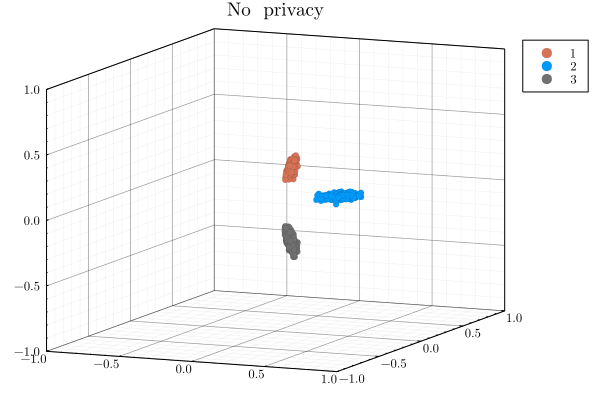

In [7]:
X, _, _ = rdpg.spectralEmbed(A, d=3, scale=false)
plt = @pipe [tuple(x...) for x in eachrow(X)]  |> scatter(_, groups=Z, lim = (-1,1), title="No  privacy")

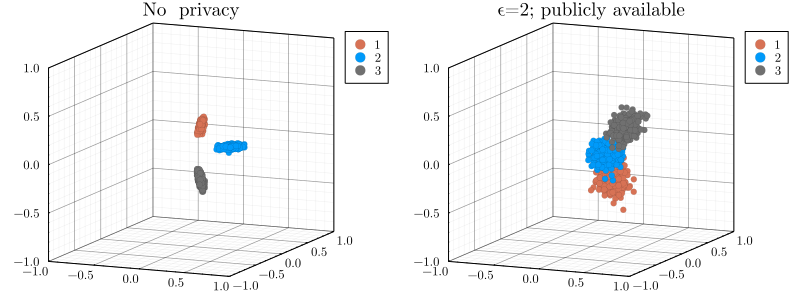

In [8]:
A_private = rdpg.edgeFlip(A, ϵ=ϵ)

A_with_eps = (A_private .- rdpg.privacy(ϵ=ϵ)) ./ (1 - 2 * rdpg.privacy(ϵ=ϵ))
X_with_eps, _ = rdpg.spectralEmbed(A_with_eps, d=3, scale=false)
plt_with_eps = @pipe [tuple(x...) for x in eachrow(X_with_eps)] |> scatter(_, groups=Z, title="ϵ=2; publicly available", lim=(-1, 1))

plot(plt, plt_with_eps, layout=(1, 2), size=(800,300))

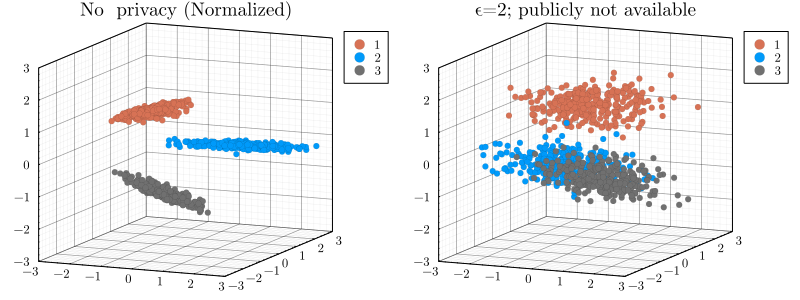

In [9]:
plt_standardized = @pipe [tuple(x...) for x in eachrow(StatsBase.standardize(ZScoreTransform, X, dims=1))] |> scatter(_, groups=Z, lim=(-3, 3), title="No  privacy (Normalized)")

X_without_eps, _ = rdpg.spectralEmbed(A_private, d=3, scale=false)
X_without_eps = StatsBase.standardize(ZScoreTransform, X_without_eps, dims=1)
plt_without_eps = @pipe [tuple(x...) for x in eachrow(X_without_eps)] |> scatter(_, groups=Z, title="ϵ=2; publicly not available", lim=(-3, 3))

plot(plt_standardized, plt_without_eps, layout=(1, 2), size=(800, 300))

## Comparison with [Seif at al. (2022)](https://arxiv.org/abs/2202.00636)

In the following, for a stochastic blockmodel with $C=3$ clusters, we examine the bottleneck distance as a function of the number of vertices $n$ when $\epsilon_n \asymp \log^k(n)$ for $k \in \{\frac 23, \frac 34, 1\}$. The result in [Seif at al. (2022)](https://arxiv.org/abs/2202.00636) requires that $\epsilon_n \asymp (\log(n)))$. 

For more information on differentially-private community detection using persistence diagrams, please see [the clustering Jupyter notebook](./clustering.ipynb).

In [10]:
repeats = 10
Ks = [2 / 3, 3 / 4, 1]
# Ks_legend = ["1/2", "2/3", "1"]
# Ks_legend = ["0.33", "0.66", "0.90"]
Ks_legend = ["0.66", "0.75", "1.00"]
N = [100, 200, 400, 600, 800, 1000, 2000];

### Dense Regime

In [11]:
p, r = 0.5, 0.1
clust = 3
n = length(N);

In [12]:
results_dense = [zeros(repeats, n) for _ in 1:length(Ks)];

prog = Progress(convert(Int, n * repeats * length(Ks)))

Random.seed!(2022)
for i in 1:n
    for j in 1:repeats
        A = generate_sbm_dense(N[i], clust, p, r)
        for k in 1:length(Ks)
        
            ϵn = 5 * log(N[i])^(Ks[k])
            error = simulate_one(A, 0, ϵn, :eps)
            results_dense[k][j, i] = error[1]
            next!(prog)
        
        end
    end
end

Progress:   1%|▍                                        |  ETA: 0:32:12

Progress:  20%|████████▍                                |  ETA: 0:01:18

Progress:  31%|████████████▉                            |  ETA: 0:00:47

Progress:  32%|█████████████▎                           |  ETA: 0:00:46

Progress:  33%|█████████████▌                           |  ETA: 0:00:45

Progress:  33%|█████████████▋                           |  ETA: 0:00:44

Progress:  34%|█████████████▉                           |  ETA: 0:00:44

Progress:  34%|██████████████                           |  ETA: 0:00:43

Progress:  35%|██████████████▎                          |  ETA: 0:00:42

Progress:  35%|██████████████▌                          |  ETA: 0:00:42

Progress:  36%|██████████████▋                          |  ETA: 0:00:41

Progress:  36%|██████████████▉                          |  ETA: 0:00:40

Progress:  37%|███████████████                          |  ETA: 0:00:40

Progress:  37%|███████████████▎                         |  ETA: 0:00:39

Progress:  38%|███████████████▍                         |  ETA: 0:00:39

Progress:  38%|███████████████▋                         |  ETA: 0:00:38

Progress:  39%|███████████████▉                         |  ETA: 0:00:38

Progress:  39%|████████████████                         |  ETA: 0:00:37

Progress:  40%|████████████████▎                        |  ETA: 0:00:37

Progress:  40%|████████████████▍                        |  ETA: 0:00:36

Progress:  40%|████████████████▋                        |  ETA: 0:00:36

Progress:  41%|████████████████▊                        |  ETA: 0:00:35

Progress:  41%|█████████████████                        |  ETA: 0:00:35

Progress:  42%|█████████████████▏                       |  ETA: 0:00:34

Progress:  42%|█████████████████▍                       |  ETA: 0:00:34

Progress:  43%|█████████████████▋                       |  ETA: 0:00:33

Progress:  43%|█████████████████▊                       |  ETA: 0:00:33

Progress:  44%|██████████████████                       |  ETA: 0:00:33

Progress:  44%|██████████████████▏                      |  ETA: 0:00:33

Progress:  45%|██████████████████▍                      |  ETA: 0:00:32

Progress:  45%|██████████████████▌                      |  ETA: 0:00:33

Progress:  46%|██████████████████▊                      |  ETA: 0:00:33

Progress:  46%|███████████████████                      |  ETA: 0:00:33

Progress:  47%|███████████████████▏                     |  ETA: 0:00:32

Progress:  47%|███████████████████▍                     |  ETA: 0:00:32

Progress:  48%|███████████████████▌                     |  ETA: 0:00:32

Progress:  48%|███████████████████▊                     |  ETA: 0:00:32

Progress:  49%|███████████████████▉                     |  ETA: 0:00:31

Progress:  49%|████████████████████▏                    |  ETA: 0:00:31

Progress:  50%|████████████████████▎                    |  ETA: 0:00:31

Progress:  50%|████████████████████▌                    |  ETA: 0:00:31

Progress:  50%|████████████████████▊                    |  ETA: 0:00:30

Progress:  51%|████████████████████▉                    |  ETA: 0:00:30

Progress:  51%|█████████████████████▏                   |  ETA: 0:00:30

Progress:  52%|█████████████████████▎                   |  ETA: 0:00:30

Progress:  52%|█████████████████████▌                   |  ETA: 0:00:29

Progress:  53%|█████████████████████▋                   |  ETA: 0:00:29

Progress:  53%|█████████████████████▉                   |  ETA: 0:00:29

Progress:  54%|██████████████████████                   |  ETA: 0:00:28

Progress:  54%|██████████████████████▎                  |  ETA: 0:00:28

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:28

Progress:  55%|██████████████████████▋                  |  ETA: 0:00:28

Progress:  56%|██████████████████████▉                  |  ETA: 0:00:27

Progress:  56%|███████████████████████                  |  ETA: 0:00:27

Progress:  57%|███████████████████████▎                 |  ETA: 0:00:27

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:27

Progress:  58%|███████████████████████▋                 |  ETA: 0:00:27

Progress:  58%|███████████████████████▉                 |  ETA: 0:00:26

Progress:  59%|████████████████████████                 |  ETA: 0:00:26

Progress:  59%|████████████████████████▎                |  ETA: 0:00:26

Progress:  60%|████████████████████████▍                |  ETA: 0:00:26

Progress:  60%|████████████████████████▋                |  ETA: 0:00:26

Progress:  60%|████████████████████████▊                |  ETA: 0:00:26

Progress:  61%|█████████████████████████                |  ETA: 0:00:26

Progress:  61%|█████████████████████████▏               |  ETA: 0:00:26

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:26

Progress:  62%|█████████████████████████▋               |  ETA: 0:00:25

Progress:  63%|█████████████████████████▊               |  ETA: 0:00:25

Progress:  63%|██████████████████████████               |  ETA: 0:00:25

Progress:  64%|██████████████████████████▏              |  ETA: 0:00:25

Progress:  64%|██████████████████████████▍              |  ETA: 0:00:25

Progress:  65%|██████████████████████████▌              |  ETA: 0:00:25

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:25

Progress:  66%|███████████████████████████              |  ETA: 0:00:24

Progress:  66%|███████████████████████████▏             |  ETA: 0:00:24

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:24

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:24

Progress:  68%|███████████████████████████▊             |  ETA: 0:00:24

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:23

Progress:  69%|████████████████████████████▏            |  ETA: 0:00:23

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:23

Progress:  70%|████████████████████████████▌            |  ETA: 0:00:23

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:22

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:22

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:22

Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:22

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:22

Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:22

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:21

Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:21

Progress:  74%|██████████████████████████████▎          |  ETA: 0:00:21

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:21

Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:21

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:21

Progress:  76%|███████████████████████████████          |  ETA: 0:00:21

Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:20

Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:20

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:20

Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:20

Progress:  78%|████████████████████████████████         |  ETA: 0:00:19

Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:19

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:19

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:19

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:18

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:18

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:18

Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:18

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:17

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:17

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:17

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:16

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:16

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:16

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:15

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:15

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:14

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:15

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:15

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:15

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:15

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:15

Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:15

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:14

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:14

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:14

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:14

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:14

Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:13

Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:13

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:13

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:12

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:12

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:11

Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:11

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:10

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:09

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:08

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:08

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:07

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:06

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:05

Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:04

Progress:  99%|████████████████████████████████████████▍|  ETA: 0:00:03

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:02

Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:03:55


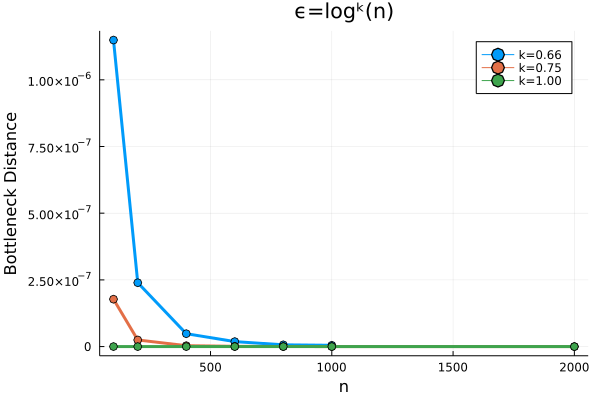

In [13]:
theme(:default)
plt_dense = plot(title="ϵ=logᵏ(n)", xlabel="n", ylabel="Bottleneck Distance")
for k in 1:length(Ks)
    plot!(plt_dense, N,
        mean(results_dense[k], dims=1)',
        # ribbon=std(results_dense[k], dims=1),
        marker=:o,
        label="k=$(Ks_legend[k])",
        lw=3, fillapha=0.01,
    )
end
plt_dense

### Sparse Regime

In [14]:
p, r = 9, 1
clust = 3
n = length(N);

In [15]:
results_sparse = [zeros(repeats, n) for _ in 1:length(Ks)];

prog = Progress(convert(Int, n * repeats * length(Ks)))

Random.seed!(2022)
for i in 1:n
    for j in 1:repeats
        A = generate_sbm_sparse(N[i], clust, p, r)
        for k in 1:length(Ks)
        
            ϵn = 5 * log(N[i])^(Ks[k])
            error = simulate_one(A, 0, ϵn, :eps)
            results_sparse[k][j, i] = error[1]
            next!(prog)
        
        end
    end
end

Progress:   1%|▍                                        |  ETA: 0:00:23

Progress:   6%|██▌                                      |  ETA: 0:00:05

Progress:  10%|████▎                                    |  ETA: 0:00:07

Progress:  15%|██████▎                                  |  ETA: 0:00:05

Progress:  19%|███████▋                                 |  ETA: 0:00:05

Progress:  20%|████████▍                                |  ETA: 0:00:05

Progress:  22%|█████████▏                               |  ETA: 0:00:05

Progress:  23%|█████████▋                               |  ETA: 0:00:06

Progress:  25%|██████████▏                              |  ETA: 0:00:06

Progress:  26%|██████████▊                              |  ETA: 0:00:05

Progress:  28%|███████████▍                             |  ETA: 0:00:05

Progress:  29%|███████████▉                             |  ETA: 0:00:06

Progress:  30%|████████████▏                            |  ETA: 0:00:06

Progress:  30%|████████████▎                            |  ETA: 0:00:06

Progress:  30%|████████████▌                            |  ETA: 0:00:06

Progress:  31%|████████████▊                            |  ETA: 0:00:06

Progress:  31%|████████████▉                            |  ETA: 0:00:07

Progress:  32%|█████████████▏                           |  ETA: 0:00:07

Progress:  32%|█████████████▎                           |  ETA: 0:00:07

Progress:  33%|█████████████▌                           |  ETA: 0:00:07

Progress:  33%|█████████████▋                           |  ETA: 0:00:07

Progress:  34%|█████████████▉                           |  ETA: 0:00:07

Progress:  34%|██████████████                           |  ETA: 0:00:07

Progress:  35%|██████████████▎                          |  ETA: 0:00:07

Progress:  35%|██████████████▌                          |  ETA: 0:00:07

Progress:  36%|██████████████▋                          |  ETA: 0:00:08

Progress:  36%|██████████████▉                          |  ETA: 0:00:08

Progress:  37%|███████████████                          |  ETA: 0:00:08

Progress:  37%|███████████████▎                         |  ETA: 0:00:08

Progress:  38%|███████████████▍                         |  ETA: 0:00:08

Progress:  38%|███████████████▋                         |  ETA: 0:00:08

Progress:  39%|███████████████▉                         |  ETA: 0:00:08

Progress:  39%|████████████████                         |  ETA: 0:00:08

Progress:  40%|████████████████▎                        |  ETA: 0:00:09

Progress:  40%|████████████████▍                        |  ETA: 0:00:09

Progress:  40%|████████████████▋                        |  ETA: 0:00:09

Progress:  41%|████████████████▊                        |  ETA: 0:00:09

Progress:  41%|█████████████████                        |  ETA: 0:00:09

Progress:  42%|█████████████████▏                       |  ETA: 0:00:09

Progress:  42%|█████████████████▍                       |  ETA: 0:00:09

Progress:  43%|█████████████████▋                       |  ETA: 0:00:09

Progress:  43%|█████████████████▊                       |  ETA: 0:00:09

Progress:  44%|██████████████████                       |  ETA: 0:00:09

Progress:  44%|██████████████████▏                      |  ETA: 0:00:10

Progress:  45%|██████████████████▍                      |  ETA: 0:00:10

Progress:  45%|██████████████████▌                      |  ETA: 0:00:10

Progress:  46%|██████████████████▊                      |  ETA: 0:00:10

Progress:  46%|███████████████████                      |  ETA: 0:00:10

Progress:  47%|███████████████████▏                     |  ETA: 0:00:11

Progress:  47%|███████████████████▍                     |  ETA: 0:00:11

Progress:  48%|███████████████████▌                     |  ETA: 0:00:11

Progress:  48%|███████████████████▊                     |  ETA: 0:00:11

Progress:  49%|███████████████████▉                     |  ETA: 0:00:11

Progress:  49%|████████████████████▏                    |  ETA: 0:00:11

Progress:  50%|████████████████████▎                    |  ETA: 0:00:11

Progress:  50%|████████████████████▌                    |  ETA: 0:00:11

Progress:  50%|████████████████████▊                    |  ETA: 0:00:12

Progress:  51%|████████████████████▉                    |  ETA: 0:00:12

Progress:  51%|█████████████████████▏                   |  ETA: 0:00:12

Progress:  52%|█████████████████████▎                   |  ETA: 0:00:12

Progress:  52%|█████████████████████▌                   |  ETA: 0:00:12

Progress:  53%|█████████████████████▋                   |  ETA: 0:00:12

Progress:  53%|█████████████████████▉                   |  ETA: 0:00:12

Progress:  54%|██████████████████████                   |  ETA: 0:00:12

Progress:  54%|██████████████████████▎                  |  ETA: 0:00:12

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:12

Progress:  55%|██████████████████████▋                  |  ETA: 0:00:12

Progress:  56%|██████████████████████▉                  |  ETA: 0:00:12

Progress:  56%|███████████████████████                  |  ETA: 0:00:12

Progress:  57%|███████████████████████▎                 |  ETA: 0:00:12

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:12

Progress:  58%|███████████████████████▋                 |  ETA: 0:00:13

Progress:  58%|███████████████████████▉                 |  ETA: 0:00:13

Progress:  59%|████████████████████████                 |  ETA: 0:00:13

Progress:  59%|████████████████████████▎                |  ETA: 0:00:13

Progress:  60%|████████████████████████▍                |  ETA: 0:00:13

Progress:  60%|████████████████████████▋                |  ETA: 0:00:13

Progress:  60%|████████████████████████▊                |  ETA: 0:00:14

Progress:  61%|█████████████████████████                |  ETA: 0:00:14

Progress:  61%|█████████████████████████▏               |  ETA: 0:00:14

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:14

Progress:  62%|█████████████████████████▋               |  ETA: 0:00:14

Progress:  63%|█████████████████████████▊               |  ETA: 0:00:14

Progress:  63%|██████████████████████████               |  ETA: 0:00:14

Progress:  64%|██████████████████████████▏              |  ETA: 0:00:14

Progress:  64%|██████████████████████████▍              |  ETA: 0:00:14

Progress:  65%|██████████████████████████▌              |  ETA: 0:00:14

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:14

Progress:  66%|███████████████████████████              |  ETA: 0:00:14

Progress:  66%|███████████████████████████▏             |  ETA: 0:00:14

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:14

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:14

Progress:  68%|███████████████████████████▊             |  ETA: 0:00:14

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:14

Progress:  69%|████████████████████████████▏            |  ETA: 0:00:14

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:14

Progress:  70%|████████████████████████████▌            |  ETA: 0:00:14

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:14

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:14

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:14

Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:14

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:14

Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:14

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:14

Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:14

Progress:  74%|██████████████████████████████▎          |  ETA: 0:00:14

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:14

Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:14

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:14

Progress:  76%|███████████████████████████████          |  ETA: 0:00:14

Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:14

Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:14

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:14

Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:14

Progress:  78%|████████████████████████████████         |  ETA: 0:00:14

Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:14

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:13

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:13

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:13

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:13

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:13

Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:13

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:13

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:12

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:12

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:12

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:12

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:12

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:11

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:11

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:11

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:11

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:12

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:12

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:12

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:12

Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:12

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:12

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:12

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:12

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:12

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:12

Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:12

Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:12

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:11

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:11

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:10

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:10

Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:09

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:09

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:08

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:08

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:07

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:06

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:05

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:05

Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:04

Progress:  99%|████████████████████████████████████████▍|  ETA: 0:00:03

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:02

Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:03:36


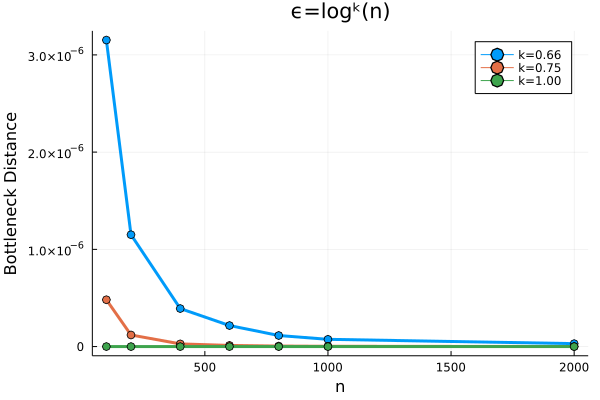

In [16]:
theme(:default)
plt_sparse = plot(title="ϵ=logᵏ(n)", xlabel="n", ylabel="Bottleneck Distance")
for k in 1:length(Ks)
    plot!(plt_sparse, N,
        mean(results_sparse[k], dims=1)',
        # ribbon=std(results_3[k], dims=1),
        marker=:o,
        label = "k=$(Ks_legend[k])",
        lw=3, fillapha=0.01,
    )
end
plt_sparse